# pyfox example


In [1]:
# This cell makes html renders of the notebook have hidden code cells.
# Especially useful for presentations. It does nothing within the
# jupyter lab environment.
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
<input type="submit" id="toggleButton" value="Show Code">
</form>''')

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import yaml

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import btmm_process

# Often there are annoying "divide by zero" warning messages. They are not useful so we ignore them.
import warnings
warnings.filterwarnings("ignore")

## Format plots

In [12]:
%matplotlib inline
# Higher resolution figures within the notebook
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi']= 100

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

### Directories

- The example notebook assumes that the directory structure is identical to the one found on github.

In [4]:
# DTS data
dir_dts_data = os.getcwd()
dir_data_cal = os.path.join(dir_dts_data, 'calibrated')
dir_data_raw = os.path.join(dir_dts_data,  'raw_netcdf')
dir_data_final = os.path.join(dir_dts_data, 'final')

# Met data
dir_ref_data = os.path.join(dir_dts_data, 'reference_temperature')

#### Load the configuration file

We need to refer to the location library later for mapping the reference sections and evaluating the calibration.

In [5]:
os.chdir(dir_dts_data)

# Read location library
cfg = os.path.join(dir_dts_data, 'example_configuration.yml')
cfg = yaml.load(cfg)
with open(cfg, 'r') as stream:
    cfg = yaml.load(stream)

# For ease of reference the location library is stored in its own dictionary.
phys_locs = cfg['location_library']
# Extract out the reference baths from the mapping library.
#Reference baths MUST be labeled with `calibration` as the `loc_type`.
bath_names = [pl for pl in phys_locs
              if phys_locs[pl]['loc_type'] == 'calibration']

# Calibrated data

This step can be run after calibrating the FODS data, e.g. within the config file

```python
calibrate_flag = True
```

This example continues with the calibrated data, evaluating the calibration performance, estimating uncertainty, and checking the mapping for other parts of the array. As before we are using a sample of data from a pair of twisted white pvc fiber optic cables in a rectangular configuration for a five minute interval at midnight. This fiber was observed as part of a set of nested rectangular fibers. It passes through 2 reference sections, cooled and heated blocks of copper, at both the very beginning and end of the fiber optic array. These reference section copper blocks give two known temperatures at four points. They were monitored using embedded pt100s. These temperatures and reference sections allow the single-ended calibration for the FODS array.

### Data check - file contents

First, let us see what is included in the netcdfs of the calibrated data. At this point in the data processing, the multiple cores have been split into their own datasets. We examine just the first of the twisted pair fiber (`core=p1` in the location library).

In [6]:
os.chdir(dir_data_final)
heat = xr.open_dataset('example_cal_channel 1_20190722-0000_p1.nc')
unheat = xr.
print(smpl_data)

<xarray.Dataset>
Dimensions:      (LAF: 2577, time: 60)
Coordinates:
  * LAF          (LAF) float64 0.06679 0.321 0.5752 0.8294 ... 654.4 654.6 654.9
  * time         (time) datetime64[ns] 2019-07-22T00:00:05 ... 2019-07-22T00:05:00
    unheated     (LAF) object ...
    heated       (LAF) float64 ...
    calibration  (LAF) object ...
    core         object ...
Data variables:
    Ps           (time, LAF) float64 ...
    Pas          (time, LAF) float64 ...
    instr_temp   (time, LAF) float64 ...
    warmProbe    (time) float64 ...
    coldProbe    (time) float64 ...
    logPsPas     (time, LAF) float64 ...
    cal_temp     (time, LAF) float64 ...
Attributes:
    LAF_beg:      0
    LAF_end:      655
    dLAF:         0.254
    dt:           5s
    unheated:     OR_NE1_Un;OR_NE2_Un;OR_NW_Un;OR_SW2_Un;OR_SW1_Un;OR_SE_Un;I...
    heated:       OR_NE1_H;OR_NE2_H;OR_NW_H;OR_SW2_H;OR_SW1_H;OR_SE_H
    calibration:  warmfar;warmnear;coldfar;coldnear


The netcdf still contains the stokes and anti-stokes intensities (`Ps` and `Pas`) and the instrument reported temperature (now renamed to `instr_temp`). Additionally, other data variables have been included: $log(\frac{P_s}{P_{as}})$, the calibrated temperature (`cal_temp`), and the temperatures within the reference sections (`coldProbe` and `warmProbe`). All variables are matrices with dimensions labeled by length along fiber (`LAF`) and time (`time`), except the reference temperatures which are just labeled by time. 

We have now added several coordinates that label locations along the fiber. These locations allow us to know that, for instance, LAFs between 505.0m and 564.0m belong to the fiber in the southeast corner of the grassfield. We can see that below. This labeling is how we convert from LAF to a physical coordinate for the data.

### Data check - performance of the calibration.

The first step is to evaluate the calibration. This allows us to estimate the uncertainty of the FODS and to identify the possibility of issues such as step-losses that need to be corrected. For this sample we withheld `coldnear` reference bath for evaluating the calibration.

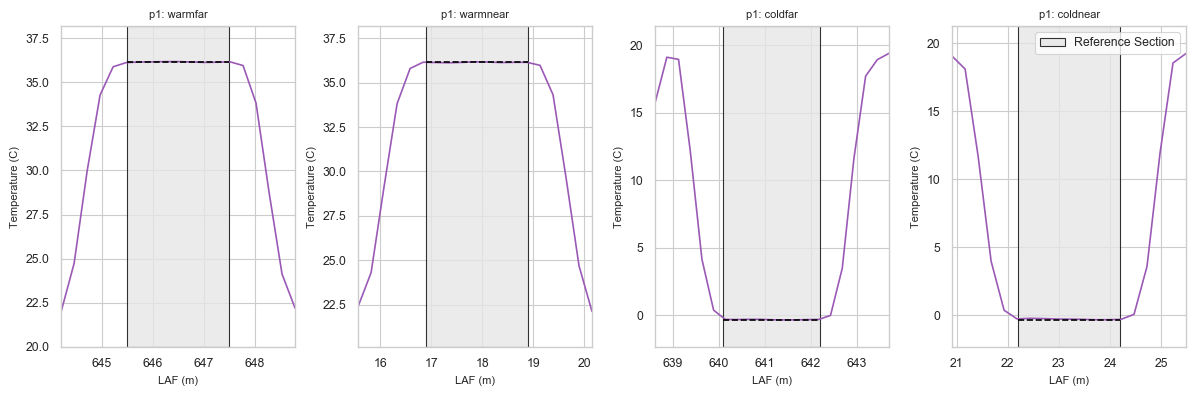

In [13]:
# Time average the data
smpl_data_mean = smpl_data.mean(dim='time')

# Reference baths
fig, axes = plt.subplots(1, len(bath_names), figsize=(12, 4))
c = 'p1'
for bn_num, bn in enumerate(bath_names):
    ax = axes[bn_num]
    ax.set_title(c + ': ' + bn)

    bath_start = phys_locs[bn]['LAF'][c][0]
    bath_end = phys_locs[bn]['LAF'][c][1]
    
    ds_bath = smpl_data_mean.sel(LAF=slice(bath_start - 1.5,
                                           bath_end + 1.5))
    
    # Fill in the "current" bath locations
    ax.fill_between([bath_start, bath_end],
                    ds_bath.cal_temp.min() - 2, ds_bath.cal_temp.max() + 2,
                    edgecolor='k', facecolor='0.9', alpha=0.8, label='Reference Section')

    # The calibrated temperature data
    ax.plot(ds_bath.LAF, ds_bath.cal_temp)
    
    # The reference probe values
    if 'warm' in bn:
        probe_name = 'warmProbe'
    elif 'cold' in bn:
        probe_name = 'coldProbe'
    probe = smpl_data_mean[probe_name]
    ax.plot([bath_start, bath_end],
            [probe, probe], 'k--')

    ax.autoscale(enable=True, tight=True)
    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('LAF (m)')

ax.legend()
fig.tight_layout()

The evaluation bath has a negligible bias, but let's get the exact number.

5.557559363000197e-05
3.7540884018602214e-05
5.143521905345722e-05
0.03701796657660745


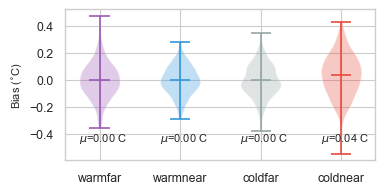

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
c = 'p1'
for bn_num, bn in enumerate(bath_names):
    bath_start = phys_locs[bn]['LAF'][c][0]
    bath_end = phys_locs[bn]['LAF'][c][1]
    
    ds_bath = smpl_data.sel(LAF=slice(bath_start,
                                      bath_end))
    # The reference probe values
    if 'warm' in bn:
        probe_name = 'warmProbe'
    elif 'cold' in bn:
        probe_name = 'coldProbe'
    probe = smpl_data_mean[probe_name]
    bias = (ds_bath.cal_temp - probe)
    print(bias.mean(dim='time').mean(dim='LAF').values)
    ax.violinplot(bias.values.flatten(), [bn_num], showmeans=True)
    ax.text(bn_num - 0.25, -0.45, '$\mu$={:01.2f} C'.format(bias.mean(dim='time').mean(dim='LAF').values))

ax.set_ylabel('Bias ($^{\circ}$C)')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(bath_names);

The validation bath has a mean bias of 0.04C, which is in line with the published bias for the full matrix inversion version of the single-ended calibration with reference sections containing more than 10 observations. However, note that the bias spreads considerably. This is an indication of one of the fundamental challenges in atmospheric deployments of FODS -- selecting appropriate scales for reducing uncertainty without sacrificing resolution and still observing the processes of interest.

### Uncertainty and scale

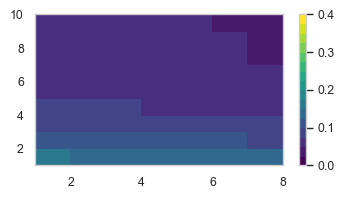

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
c = 'p1'
loc_name = 'coldnear'
start = phys_locs[loc_name]['LAF'][c][0]
end = phys_locs[loc_name]['LAF'][c][1]

ds_loc = smpl_data.sel(LAF=slice(start, end))
probe = smpl_data_mean[probe_name]

t_agg = np.arange(1, 10)
t_agg_plot = np.arange(t_agg.min(), t_agg.max() + 2)
x_agg = np.arange(1, 8)
x_agg_plot = np.arange(x_agg.min(), x_agg.max() + 2)

unc = np.zeros((len(t_agg), len(x_agg)))
for nt, t in enumerate(t_agg):
    for nx, x in enumerate(x_agg):
        smooth_ds = ds_loc.rolling(LAF=x, center=True).mean().rolling(time=t, center=True).mean()
        unc[nt, nx] = smooth_ds.std(dim='time').mean(dim='LAF').cal_temp

im = ax.pcolormesh(x_agg_plot, t_agg_plot, unc,
                   cmap=plt.get_cmap('viridis', 16), vmin=0, vmax=.4)
fig.colorbar(im)

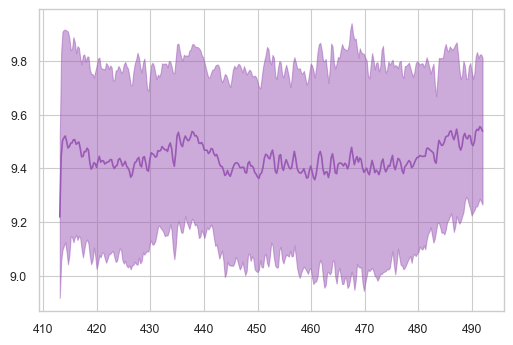

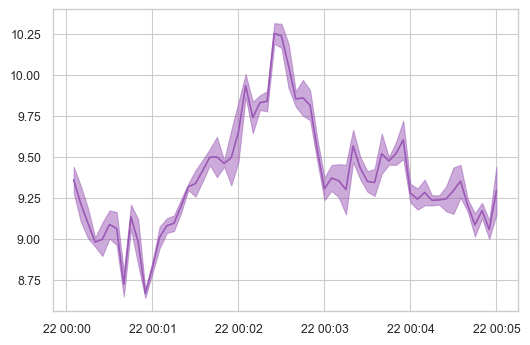

In [58]:
loc_name = 'IR_SW1'
start = phys_locs[loc_name]['LAF'][c][0]
end = phys_locs[loc_name]['LAF'][c][1]
ds_loc = smpl_data.sel(LAF=slice(start, end))

fig, ax = plt.subplots(1, 1)
ax.fill_between(ds_loc.LAF,
                ds_loc.cal_temp.mean(dim='time') - ds_loc.cal_temp.std(dim='time'),
                ds_loc.cal_temp.mean(dim='time') + ds_loc.cal_temp.std(dim='time'),
                color=flatui[0], alpha=0.5,
               )
ax.plot(ds_loc.LAF, ds_loc.cal_temp.mean(dim='time'))

fig, ax = plt.subplots(1, 1)
ds_loc = ds_loc.cal_temp.sel(LAF=slice(450, 451))
ax.fill_between(ds_loc.time.values,
                ds_loc.mean(dim='LAF') - ds_loc.std(dim='LAF'),
                ds_loc.mean(dim='LAF') + ds_loc.std(dim='LAF'),
                color=flatui[0], alpha=0.5,
               )
ax.plot(ds_loc.time, ds_loc.mean(dim='LAF'))
